# IDS Project - Intrusion Detection System

As part of my Master's degree in Artificial Intelligence and Engineering at the University of Paris 8, I am required to submit a project exploring a real-world use case of artificial intelligence. This project aims to develop an **Intrusion Detection System (IDS)** using machine learning techniques. The primary goal is to identify abnormal behaviors and potential DDoS attacks in a network using supervised models (Random Forest, SVC) and unsupervised models (Autoencoder).

## Project Objectives
1. Detect abnormal behaviors in a network using machine learning techniques.
2. Compare the performance of multiple models (Autoencoder, Random Forest, SVC).
3. Analyze results and suggest future improvements.


### Notebook Content
1. Data Preprocessing
2. Model Training
3. Evaluation and Results
4. Error Analysis
5. Conclusion

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, Dropout

In [22]:
# Charger les données
data = pd.read_csv("data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

### Column display

In [ ]:
print(data.columns)

' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count',
       ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count',
       ' ECE Flag Count', ' Down/Up Ratio', ' Average Packet Size',
       ' Avg Fwd Segment Size', ' Avg Bwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk',
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes',
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' act_data_pkt_fwd',
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min',
       ' Label',

### Class Breakdown Viewer

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=data[' Label'], palette="muted")
plt.title("Répartition des Classes (BENIGN vs ATTACK)")
plt.xlabel("Classe")
plt.ylabel("Nombre d'Instances")
plt.tight_layout()
plt.show()

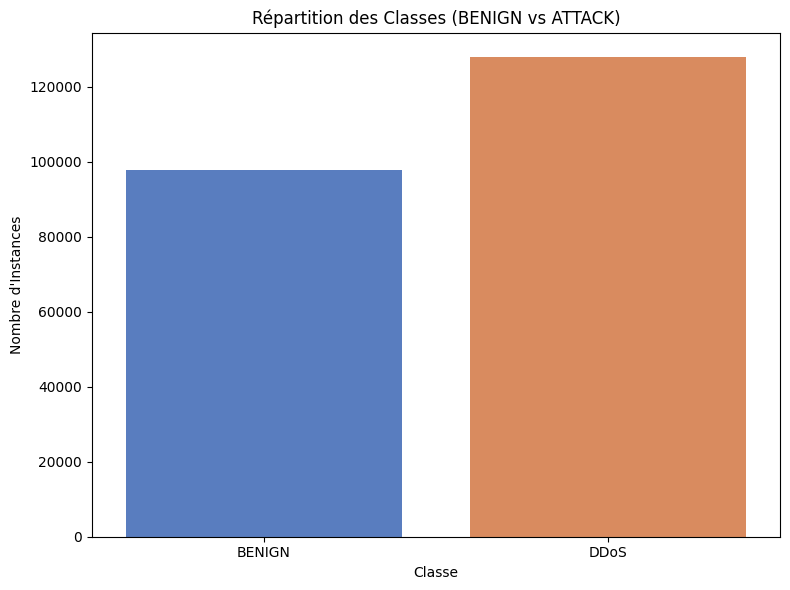

Here, the 'Benign' data represents normal network traffic, while 'DDoS' represents attack traffic.

## Data Preprocessing
This phase aims to preprocess the dataset to optimize it for model training.
### Steps:
1. Remove duplicates.
2. Handle missing values.
3. Normalize the features.
4. Encode categorical columns for model training.

In [ ]:
# Remove spaces from column names
data.columns = data.columns.str.strip()

# Deleting duplicates
data = data.drop_duplicates()

# Missing values management (remove columns with > 80% NaN)
data = data.dropna(axis=1, thresh=len(data) * 0.8)

# Encoding the 'Label' column
data['Label'] = data['Label'].map(lambda x: 1 if x == 'BENIGN' else 0)

# Outlier correction
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
for col in ['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s']:
    if col in numerical_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        data = data[(data[col] >= Q1 - 1.5 * IQR) & (data[col] <= Q3 + 1.5 * IQR)]

# Characteristic standardization
features = data.drop('Label', axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Separation of X and y
X = features_scaled
y = data['Label'].values

# Division of data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Once the data is preprocessed, we can begin training our models and observing the first results.

### First Model: Random Forest

#### Why Random Forest?
Random Forest is a robust and versatile machine learning algorithm that works well for both classification and regression tasks. Its relevance for this project lies in several key advantages:

1. **Handles Imbalanced Data Well:** Random Forest can manage datasets with varying distributions, such as the benign and DDoS traffic in this project.

2. **Feature Importance:** The algorithm provides insights into which features contribute the most to the predictions, helping to understand the network traffic patterns.

3. **Robustness to Overfitting:** By combining multiple decision trees, Random Forest reduces the risk of overfitting compared to single-tree methods.

4. **Accuracy and Scalability:** It achieves high accuracy for classification tasks like intrusion detection, and it is computationally efficient for medium-sized datasets.

5. **Works on Nonlinear Data:** Random Forest can capture nonlinear relationships between features, which is essential for detecting complex network anomalies.

### Training Phase with Random Forest

In [ ]:
model_RandomF = RandomForestClassifier(random_state=42)

model_RandomF.fit(X_train, y_train)

### Prediction Phase with Random Forest

In [ ]:
y_pred_rf = model_RandomF.predict(X_test)

### Graphical Visualization of Results

In [ ]:
Ddos_réel_RandomF = (y_test == 1).sum()
Ddos_prédit_RandomF = (y_pred_rf == 1).sum()

print((y_test == 1).sum())
print((y_pred_rf == 1).sum())
plt.figure(figsize=(8, 6))
sns.barplot(x=["DDOS réelle", "DDOS prédit"], y=[Ddos_réel_RandomF, Ddos_prédit_RandomF], palette="Blues_d")
plt.title("Réalité vs Prédiction")
plt.ylabel("Nombre d'instance")
plt.show()

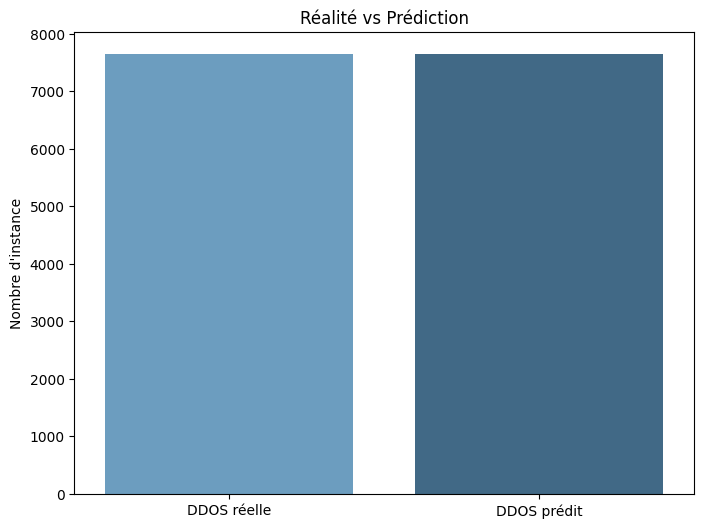

### Visualization with Accuracy and Classification Report

To evaluate the performance of the Random Forest model, key metrics such as **Accuracy** and the **Classification Report** are analyzed and visualized.

In [ ]:
# Évaluer la performance
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

'''scores = cross_val_score(model_RandomF, X, y, cv=5)  # 5-fold cross-validation
print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())'''

### Model Evaluation: Accuracy and Classification Report

#### **Accuracy**
- **Value:** 0.9999
- This indicates that the model correctly classified **99.99%** of the instances in the dataset.

#### **Classification Report**
A detailed breakdown of the model's performance for each class (Benign and DDoS):

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0** (Benign) | 1.00 | 1.00 | 1.00 | 17,268 |
| **1** (DDoS)   | 1.00 | 1.00 | 1.00 | 7,648  |

- **Precision:** 
  - For both classes, the model predicted positive samples with near-perfect accuracy.
- **Recall:** 
  - All true positives were correctly identified by the model for both Benign and DDoS classes.
- **F1-Score:** 
  - The harmonic mean of precision and recall is 1.00, showcasing an excellent balance.

#### **Overall Metrics**
| Metric         | Value |
|----------------|-------|
| **Accuracy**   | 1.00  |
| **Macro Avg**  | 1.00  |
| **Weighted Avg** | 1.00  |

These metrics demonstrate that the model performs exceptionally well, achieving nearly perfect classification results on the test data. However, such high accuracy may indicate potential overfitting, which should be further investigated

### Why is the Accuracy Very High?

The exceptionally high accuracy (0.9999) could be attributed to the following factors:

1. **Clean Dataset:**
   - If the dataset has been extensively preprocessed (e.g., removal of noise, normalization, and outlier handling), it becomes easier for the model to achieve near-perfect predictions.

2. **Lack of Real-World Variability:**
   - The dataset (CICIDS 2017) might not fully represent real-world network traffic, leading to inflated performance on synthetic data.

3. **Low Complexity of the Problem:**
   - If the features in the dataset are highly separable (e.g., clear distinctions between benign and attack traffic), the model may find it relatively easy to classify instances correctly.

### Second Model: Support Vector Classifier (SVC)

#### Why Use SVC?

The Support Vector Classifier (SVC) from scikit-learn is particularly well-suited for this project due to its ability to handle high-dimensional data and provide precise classification. Here’s why SVC is a relevant choice for an intrusion detection system:

1. **Effective for Binary Classification:**

2. **Works Well on Small to Medium Datasets:**

3. **Handles Nonlinear Relationships:**
   - Using kernel functions (e.g., radial basis function or polynomial kernels), SVC can capture complex relationships between features that may not be linearly separable.

### Training Phase with SVC

In [ ]:
SVCmodel = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
SVCmodel.fit(X_train, y_train)

### Prediction Phase with Random Forest

In [ ]:
y_pred_SVC = SVCmodel.predict(X_test)

### Graphical Visualization of Results

In [ ]:
Ddos_réel_SVC = (y_test == 1).sum()
Ddos_prédit_SVC = (y_pred_SVC == 1).sum()

# Data réel vs Data prédit
plt.figure(figsize=(8, 6))
sns.barplot(x=["DDOS réelle", "DDOS prédit"], y=[Ddos_réel_SVC, Ddos_prédit_SVC], palette="Blues_d")
plt.title("Réalité vs Prédiction")
plt.ylabel("Nombre d'instance")
plt.show()

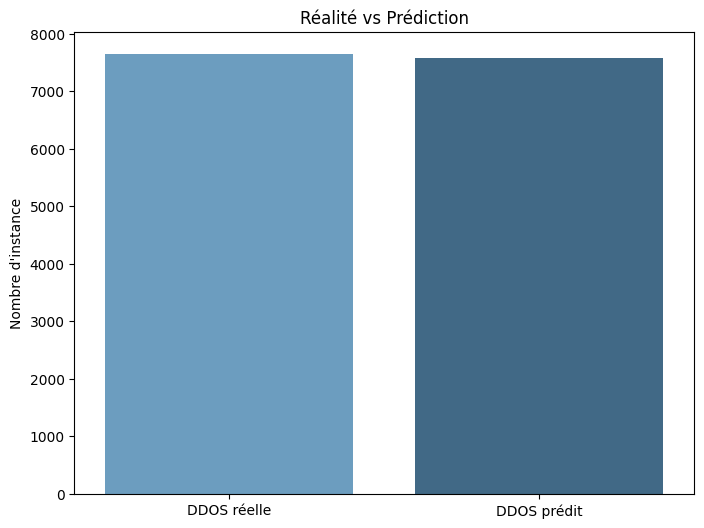

### Visualization with Accuracy and Classification Report

To evaluate the performance of the Random Forest model, key metrics such as **Confusion matrix**, **Accuracy** and the **Classification Report** are analyzed and visualized.

In [ ]:
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_SVC))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_SVC))

print(f"Accuracy : {accuracy_score(y_test, y_pred_SVC):.4f}")

### Model Evaluation: Support Vector Classifier (SVC)

#### **Confusion Matrix**
The confusion matrix for the SVC model is as follows:
[[17265 3] [ 7 7641]]


**Interpretation:**
- **True Positives (TP):** 17,265 instances of class `0` (Benign) correctly classified.
- **True Negatives (TN):** 7,641 instances of class `1` (DDoS) correctly classified.
- **False Positives (FP):** 3 benign instances misclassified as DDoS.
- **False Negatives (FN):** 7 DDoS instances misclassified as benign.

#### **Classification Report**
A detailed breakdown of the performance metrics for each class:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0** (Benign) | 1.00 | 1.00 | 1.00 | 17,268 |
| **1** (DDoS)   | 1.00 | 1.00 | 1.00 | 7,648  |

- **Precision:** Both classes are predicted with near-perfect precision, minimizing false positives.
- **Recall:** The model correctly identifies nearly all true positives for both classes.
- **F1-Score:** Indicates a perfect balance between precision and recall for both classes.

#### **Overall Metrics**
| Metric         | Value |
|----------------|-------|
| **Accuracy**   | 0.9996 |
| **Macro Avg**  | 1.00  |
| **Weighted Avg** | 1.00  |

### Why is the Accuracy Very High for SVC?

The exceptionally high accuracy (99.96%) for the Support Vector Classifier (SVC) can be explained by several factors:

1. **Highly Distinguishable Features:**
   - The dataset contains features that clearly separate the benign traffic from DDoS attacks.
   - SVC excels at finding optimal decision boundaries, especially in datasets with well-defined patterns.

2. **Balanced Dataset after Preprocessing:**
   - The data preprocessing steps, such as normalization and removal of outliers, likely improved the separability of the classes.
   - Any imbalance in the dataset was addressed, reducing the risk of bias toward one class.

3. **Kernel Function:**
   - The SVC model likely used a kernel function (e.g., RBF kernel) that effectively captured the nonlinear relationships in the data, resulting in better classification performance.

4. **Synthetic Dataset:**
   - The CICIDS 2017 dataset, while comprehensive, may not fully represent real-world variability. This controlled environment often results in higher-than-expected model performance.

6. **Minimal Noise in Data:**
   - Extensive preprocessing likely removed much of the noise, making it easier for the model to achieve high accuracy during testing.


### Third Model: Autoencoder with TensorFlow

#### Why Use an Autoencoder?

An autoencoder is a powerful neural network architecture designed for unsupervised learning, making it an excellent choice for anomaly detection in this project. Here’s why it is relevant:

1. **Unsupervised Anomaly Detection:**
   - Unlike supervised models, an autoencoder does not require labeled data to identify anomalies.
   - It learns to compress (encode) and reconstruct (decode) the input data, making it ideal for detecting deviations from normal network traffic.

3. **Handles Complex Features:**
   - With multiple layers and nonlinear activation functions, the autoencoder captures complex relationships between features, which are crucial for identifying subtle anomalies in network traffic.

6. **Focus on Normal Data:**
   - In intrusion detection, most traffic is benign, and attacks are rare. Autoencoders are trained only on normal data, making them sensitive to unusual patterns during inference.

In [ ]:
# Defining the Autoencoder Architecture

input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Training the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

#### **Epoch Logs**
- **Initial Epochs:** The model starts with a relatively high training loss (`0.6500`) and validation loss (`0.4693`).
- **Middle Epochs:** Both losses decrease steadily as the model fine-tunes its weights.
- **Final Epochs:** By epoch 50:
  - Training loss: `0.5811`
  - Validation loss: `0.4567`

### Visualization of training losses

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Évolution de la perte au cours des époques')
plt.xlabel('Époques')
plt.ylabel('Perte (Mean Squared Error)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

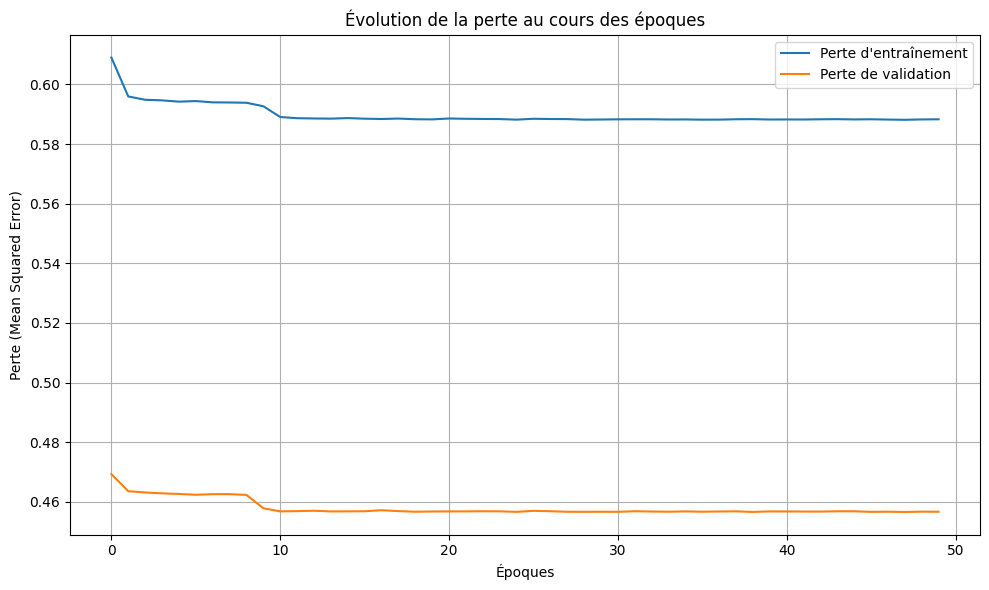

#### **Graph Summary**
- **Training Loss:** The blue line represents the loss (Mean Squared Error) during training. It shows a steady decline over epochs, eventually stabilizing around `0.60`.
- **Validation Loss:** The orange dashed line represents the loss on the validation set. It starts higher (`~0.47`) but quickly drops and stabilizes around `0.46`.

#### **Is This a Good Result?**
**Positives:**
1. **Stability:** Both the training and validation losses stabilize after a few epochs, indicating the model has reached its optimal learning state.
2. **No Overfitting:** The training loss and validation loss remain close to each other throughout the process, suggesting that the model generalizes well to unseen data and is not overfitting.

**Negatives:**
1. **High Loss Values:** The final loss values (`0.60` for training and `0.46` for validation) are relatively high for an autoencoder. This indicates that the model is not reconstructing the input data as accurately as desired.
2. **Slow Convergence:** The loss values decrease very gradually after the first few epochs, which could mean the learning rate is too low or the architecture is not optimal.

#### **What Could Be Improved?**
1. **Refining the Model Architecture:**
   - Increase or decrease the number of neurons in the encoder and decoder layers to see if it improves reconstruction accuracy.
   - Experiment with additional dropout layers to enhance regularization.

2. **Hyperparameter Tuning:**
   - Adjust the learning rate of the optimizer for faster convergence.
   - Test different batch sizes to optimize the training process.

3. **Additional Training Epochs:**
   - Extend the training beyond 50 epochs to see if the loss can decrease further.
   - Use early stopping to automatically terminate training when no improvement is observed.

4. **Investigate Data Quality:**
   - Check if there is noise or outliers in the training data that may be impacting reconstruction accuracy.
   - Apply further preprocessing steps, such as feature selection or outlier removal.


### Textual Visualization: Classification Report and AUC-ROC

In [ ]:
X_reconstructed = autoencoder.predict(X)
reconstruction_errors = np.mean(np.power(X - X_reconstructed, 2), axis=1)

precision, recall, thresholds = precision_recall_curve(y, reconstruction_errors)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Meilleur seuil basé sur le F1-score : {best_threshold}")


# Predicting anomalies
y_pred = (reconstruction_errors > best_threshold).astype(int)

# Assessing performance
print("\nRapport de classification :")
print(classification_report(y, y_pred))
print(f"AUC-ROC : {roc_auc_score(y, reconstruction_errors):.4f}")

### Best Threshold Based on F1-Score: `0.223`

#### **Classification Report**
The classification report at the optimal threshold provides the following results:
          precision    recall  f1-score   support

       0       0.96      0.79      0.87     86340
       1       0.66      0.92      0.77     38239

accuracy                           0.83    124579

macro avg 0.81 0.86 0.82 124579 weighted avg 0.87 0.83 0.84 124579

- **Accuracy:** `0.83` – The model correctly predicts 83% of all cases.
- **Precision (Class 1):** `0.66` – Some false positives for anomalies.
- **Recall (Class 1):** `0.92` – High ability to detect most anomalies.
- **F1-Score (Class 1):** `0.77` – Good balance between precision and recall.

#### **AUC-ROC:**
- **Score:** `0.8938` – The model performs well in separating anomalies and benign traffic.

### Reconstruction error graph

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors[y == 1], bins=50, alpha=0.6, color='blue', label='Bénin')
plt.hist(reconstruction_errors[y == 0], bins=50, alpha=0.6, color='red', label='Attaque')
plt.axvline(best_threshold, color='black', linestyle='--', label='Seuil')
plt.title("Distribution de l'erreur de reconstruction")
plt.xlabel("Erreur de reconstruction")
plt.ylabel("Fréquence")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

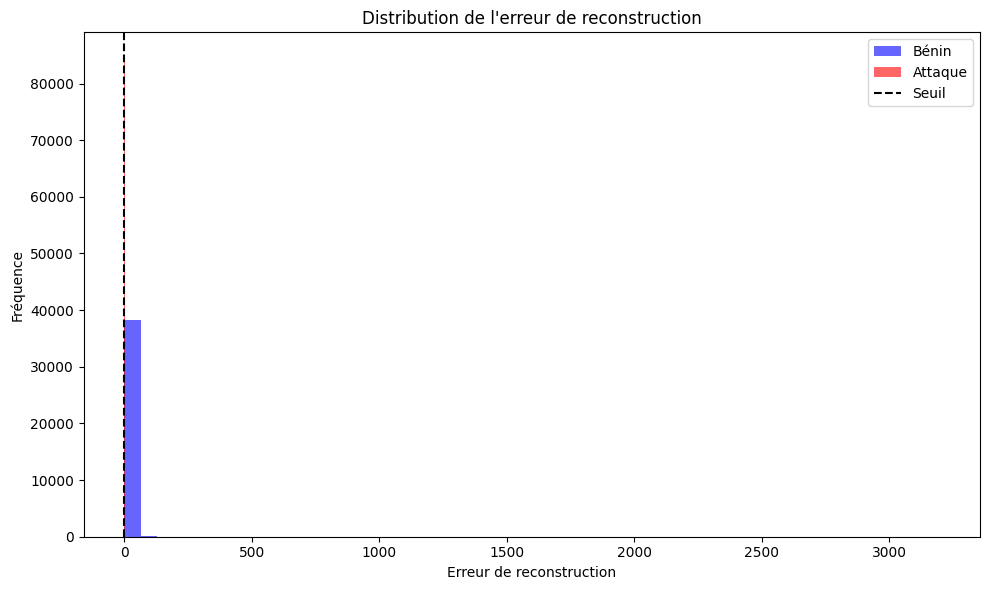

### Graph: Reconstruction Error Distribution

#### **Analysis**
- The graph displays the **distribution of reconstruction errors** for two classes:
  - **Benign (Blue):** Represents normal network traffic.
  - **Anomalies (Red):** Represents detected attacks.
- The **dotted black line** indicates the threshold chosen based on the F1-score (`0.223`).

#### **Observations**
1. **Separation of Classes:**
   - Most benign data points have reconstruction errors below the threshold.
   - Most anomalies have reconstruction errors above the threshold.
   - This shows the model is generally effective at distinguishing between benign traffic and anomalies.
   
2. **Class Overlap:**
   - A slight overlap exists near the threshold, leading to:
     - **False Positives:** Benign points above the threshold classified as anomalies.
     - **False Negatives:** Anomalies below the threshold classified as benign.

3. **Class Imbalance:**
   - The blue bar (benign) is significantly taller, reflecting the dataset’s imbalance.

#### **Strengths**
- The chosen threshold works well in separating benign traffic from anomalies.
- Most errors for benign traffic are small, indicating accurate reconstruction.

#### **Improvements**
1. **Better Separation:**
   - The model could be improved to reduce the overlap near the threshold. 
   - Techniques like adjusting the architecture (e.g., adding layers) or fine-tuning hyperparameters might help.
2. **Handling Class Imbalance:**
   - Use oversampling techniques (e.g., SMOTE) to balance the classes during training.

### ROC curve visualization

In [ ]:
fpr, tpr, thresholds = roc_curve(y, reconstruction_errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Ligne de référence
plt.title("Courbe ROC")
plt.xlabel("Taux de Faux Positifs (False Positive Rate)")
plt.ylabel("Taux de Vrais Positifs (True Positive Rate)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


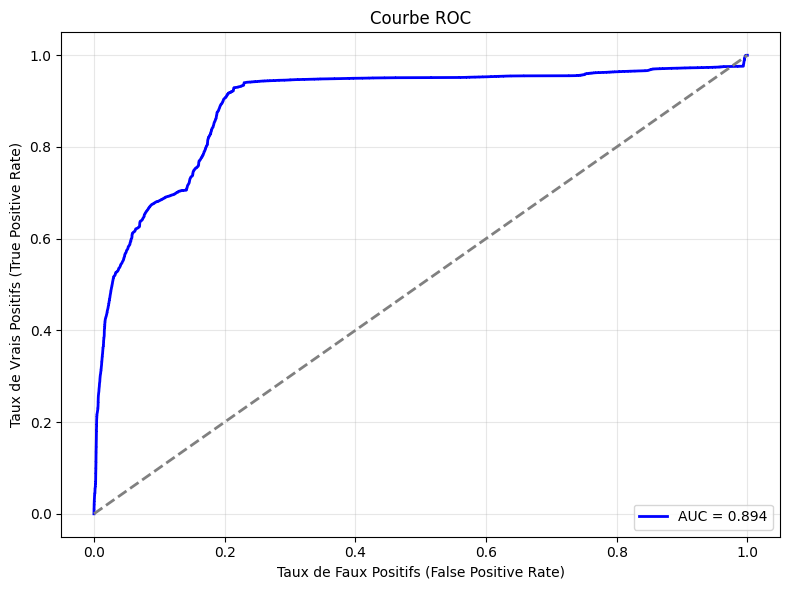

### Graph: ROC Curve

#### **Analysis**
- This curve illustrates the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** for various thresholds.
- The **blue line** represents the model's performance, while the **dashed diagonal line** shows a random classifier's performance.
- The **AUC (Area Under Curve)** score is `0.898`, indicating strong performance.

#### **Observations**
1. **Model Performance:**
   - The curve is close to the top-left corner, signifying the model's high ability to distinguish between benign traffic and anomalies.
   - An AUC score of `0.898` suggests the model performs well overall.

2. **False Positive Management:**
   - At low false positive rates (left side of the graph), the true positive rate remains high, demonstrating that the model is effective at detecting anomalies without many false alarms.

#### **Strengths**
- **High AUC Score:** The model achieves nearly 90% discrimination capability.
- **Good TPR at Low FPR:** Indicates reliability in identifying anomalies while minimizing false positives.

#### **Improvements**
1. **Optimize Thresholds:**
   - Investigate specific thresholds to balance false positives and false negatives, depending on application needs.
2. **Class Imbalance Impact:**
   - Improve the balance between benign and anomalous samples during training to further refine performance.

### Observations and Improvements for the Autoencoder

Through various graphical analyses, we observed that while the **Autoencoder** model performs reasonably well in detecting anomalies, there is still **room for improvement** in its performance.

#### **Additional Strategies Tried**
Throughout this project, multiple strategies were implemented to refine the model and experiment with different approaches.

## Let's Start with Preprocessing

We introduced the following improvements to the preprocessing phase:

- **Missing Data Imputation**: Missing values were replaced with the median of each column. The median is robust to outliers and helps preserve the overall distribution of the dataset.

- **Feature Scaling**: All features were scaled to a range of [0, 1] to ensure consistency and avoid bias towards features with larger magnitudes. This step is especially critical for models that rely on distance metrics and for deep learning algorithms.

- **Dimensionality Reduction**: Principal Component Analysis (PCA) was applied to reduce the dimensionality of the dataset while retaining 95% of the original variance. This improves computational efficiency and reduces the risk of overfitting.


In [ ]:
# Prétraitement

# 1. Suppression des doublons
data = data.drop_duplicates()

# Supprimer les espaces dans les noms des colonnes
data.columns = data.columns.str.strip()

# 3. Encodage de la colonne 'Label'
if 'Label' in data.columns:
    label_col = 'Label'
elif ' Label' in data.columns:
    label_col = ' Label'
else:
    raise KeyError("La colonne 'Label' ou ' Label' est introuvable.")
data[label_col] = data[label_col].map(lambda x: 1 if x == 'BENIGN' else 0)

# Remplacer les Valeurs inf par une Valeur Fixe ou NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Gestion des données manquantes
# Remplacer les valeurs manquantes par la médiane de chaque colonne
imputer = SimpleImputer(strategy='median')
data[data.columns] = imputer.fit_transform(data)

# 4. Correction des valeurs aberrantes (Flow Duration, Flow Bytes/s, Flow Packets/s)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
for col in ['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s']:
    if col in numerical_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        data = data[(data[col] >= Q1 - 1.5 * IQR) & (data[col] <= Q3 + 1.5 * IQR)]

# Séparer les caractéristiques et les étiquettes
X = data.drop(label_col, axis=1)
y = data[label_col]

# 4. Normalisation des données (MinMaxScaler)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. Réduction de la dimensionnalité (PCA)
dimRed = PCA(n_components=0.95)
XdimRed = dimRed.fit_transform(X_scaled)

## Combining the Autoencoder with Other Models

Another strategy to improve the performance of the autoencoder was to combine it with supervised models such as SVC or Random Forest.

- **Why Combine Models?**  
  The autoencoder is an unsupervised model that excels at capturing the underlying patterns in the data by reconstructing the input. However, it may struggle to separate benign and anomalous data points when the patterns are subtle. By combining the autoencoder with supervised models:
  
  - **Refinement of Anomalies**: The reconstruction error from the autoencoder can serve as an additional feature or threshold to detect anomalies more effectively. The supervised models can then classify these anomalies with better precision.
  - **Leveraging Strengths**: While the autoencoder identifies patterns in the data, models like SVC or Random Forest use labeled data to fine-tune the decision boundaries, improving accuracy.
  - **Improved Generalization**: The combination can reduce overfitting in both models by merging their complementary strengths, leading to better generalization on unseen data.


#### The corresponding code is =>

In [ ]:
# With randomforest 

# Separate benign data to train the autoencoder
X_train_benign = X_train[y_train == 1]
X_test_benign = X_test[y_test == 1]

# Définir l'architecture de l'autoencodeur
input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)  # Représentation latente

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

# Define autoencoder architecture
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train_benign, X_train_benign,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_benign, X_test_benign),
    verbose=1
)

# Extracting latent representations
encoder = Model(inputs=autoencoder.input, outputs=encoded)

# Apply encoder to obtain latent representations
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

# Using Random Forest for classification
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_latent, y_train)

# Evaluating supervised model performance
y_pred = rf_model.predict(X_test_latent)


In [ ]:
# With svc 


X_train_benign = X_train[y_train == 1]
X_test_benign = X_test[y_test == 1]

input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train_benign, X_train_benign,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_benign, X_test_benign),
    verbose=1
)

encoder = Model(inputs=autoencoder.input, outputs=encoded)

X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

mixedSCV_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
mixedSCV_model.fit(X_train_latent, y_train)

y_pred = mixedSCV_model.predict(X_test_latent)

### Visualization of loss curve, reconstruction error and ROC curve =>

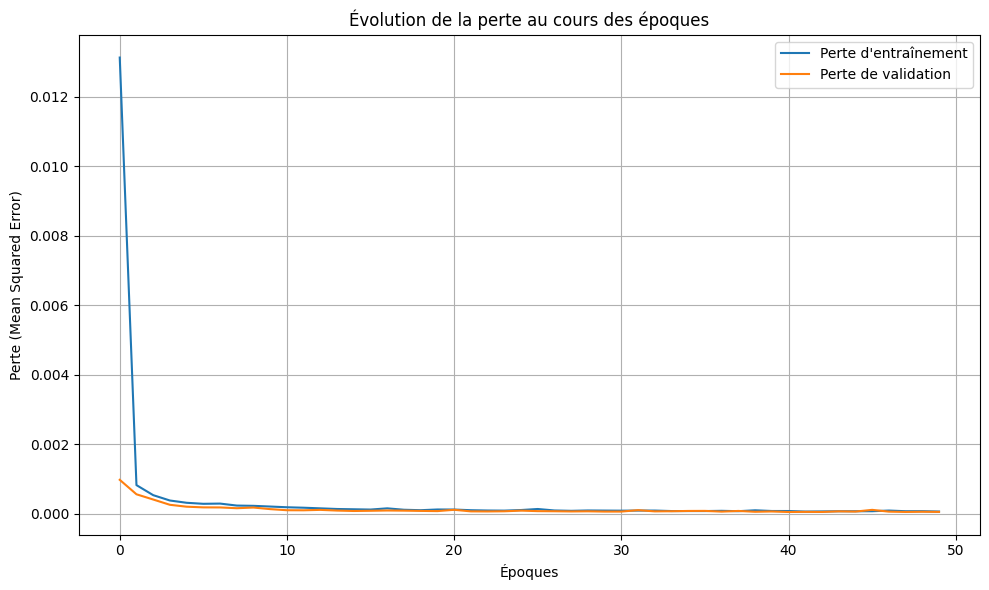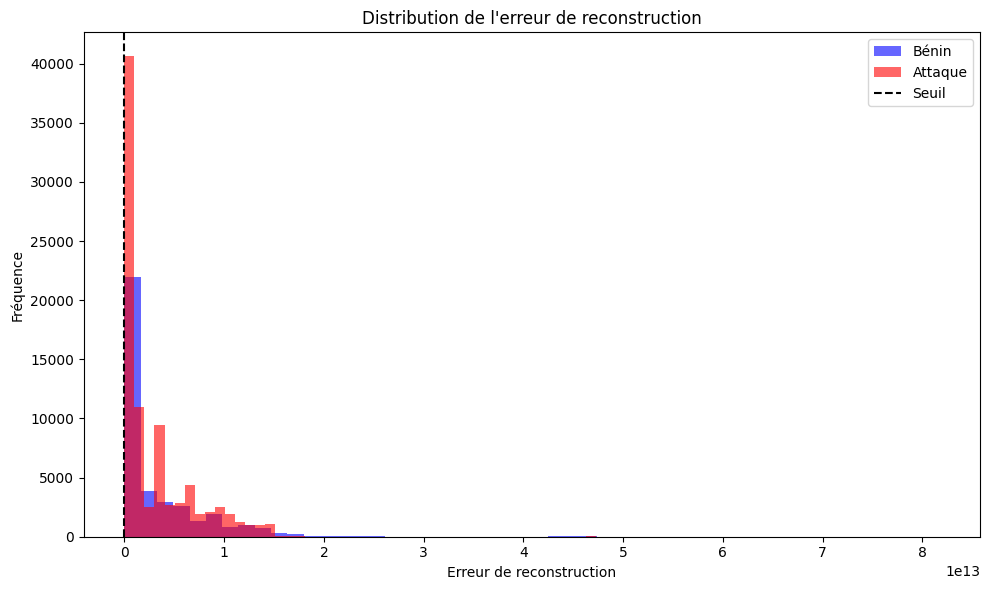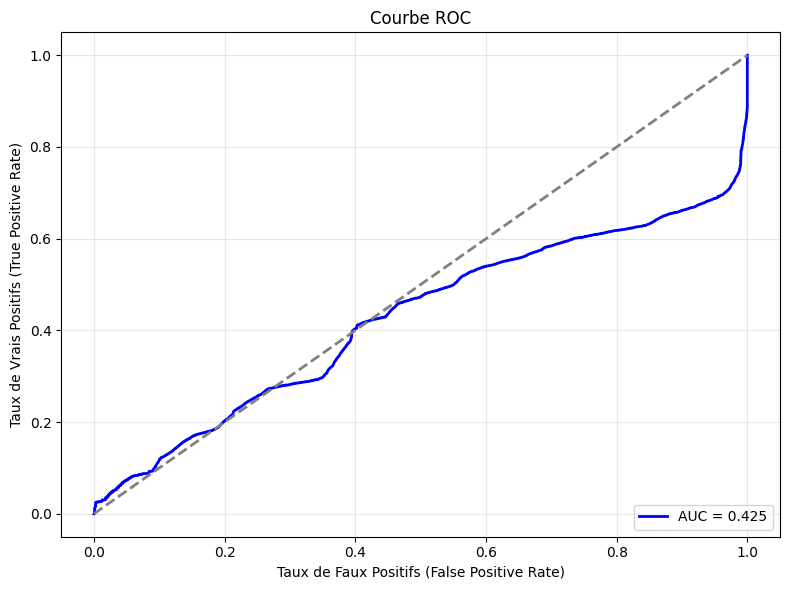

# General Analysis of Results

## Strengths:
- The autoencoder demonstrates some capability in separating benign traffic from anomalies, as seen in the reconstruction error distribution. This suggests the model has learned to some extent the patterns of benign data.
- The training and validation loss curves show stable learning with no significant signs of overfitting.

## Weaknesses:
- The overall performance is suboptimal, as indicated by the ROC curve's low AUC score (0.425). This reflects poor balance between true positive and false positive rates.
- There is considerable overlap between the reconstruction errors of benign and anomalous data, leading to potential misclassifications.
- The autoencoder struggles to generalize effectively, as shown by the high range of reconstruction errors for anomalies..

## Why is it low ?
- I strongly suggests that the preprocessing might be the root of the problem.

# Conclusion and Future Directions

The project successfully explored the development of an Intrusion Detection System (IDS) using both supervised and unsupervised machine learning models. Despite some promising results, there are clear areas for improvement and future exploration.

## What We Achieved
### Preprocessing Pipeline
- Implemented robust preprocessing steps including feature scaling, outlier handling, missing data imputation, and dimensionality reduction.
- Improved data consistency and model compatibility through feature engineering.

### Model Comparisons
- Tested supervised models like Random Forest and SVC, as well as an unsupervised Autoencoder.
- Demonstrated the potential of combining unsupervised anomaly detection (Autoencoder) with supervised learning models for enhanced accuracy.

### Visualization and Analysis
- Generated detailed visualizations for training loss, reconstruction errors, and ROC curves to evaluate model performance.


## Future Directions

### Advanced Preprocessing
- Refine the preprocessing techniques to better adapt to the dataset, such as applying domain-specific feature engineering or advanced outlier detection methods.
- Explore feature selection methods to focus on the most relevant features for anomaly detection.

### Model Exploration
- Investigate other advanced machine learning models like Gradient Boosting Machines (e.g., XGBoost, LightGBM) or deep learning architectures like LSTMs and Transformers for time-series anomaly detection.

### Dataset Expansion
- Increase the dataset's size and diversity by including more attack types and network conditions. This will improve the model's generalization and robustness.

### Ensemble Methods
- Experiment with model ensembles that combine multiple classifiers to leverage their strengths and mitigate weaknesses.

### Real-Time Detection
- Adapt the models to work in real-time scenarios for continuous network monitoring, ensuring the system can handle live traffic.



## Conclusion
This project provided valuable insights into the challenges and potential of building machine learning-based IDS systems. While the results are encouraging, they highlight the importance of preprocessing and model selection. By improving the preprocessing pipeline, exploring advanced models, and expanding the dataset, the IDS can become more robust and capable of detecting a broader range of threats. 

The project lays the groundwork for future exploration in anomaly detection and network security, with the potential to make meaningful contributions to the field.

# Thanks for reading !